Step 1: Setup and Imports


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


Step 2: Load and Encode Dataset


In [12]:
# Load the text file (ensure the file is in your working directory)
from pathlib import Path
p = Path(r'E:\slfi\Assignment\assignment-2\Assignment2\slf2\Assign-2\dataset\Pride_and_Prejudice-Jane_Austen.txt')
text = p.read_text(encoding='utf-8')

chars = sorted(set(text))
vocab_size = len(chars)
char2idx = {ch: idx for idx, ch in enumerate(chars)}
idx2char = {idx: ch for idx, ch in enumerate(chars)}
encoded_text = np.array([char2idx[c] for c in text], dtype=np.int32)


Step 3: Split into Train & Validation


In [13]:
split = int(0.9 * len(encoded_text))
train_encoded = encoded_text[:split]
val_encoded = encoded_text[split:]


Step 4: Batch Preparation


In [14]:
class CharDataset(Dataset):
    def __init__(self, encoded_text, seq_len):
        self.data = encoded_text
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) - self.seq_len
    def __getitem__(self, idx):
        x = self.data[idx      :idx+self.seq_len]
        y = self.data[idx+1    :idx+self.seq_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

SEQ_LEN = 100
BATCH_SIZE = 64

train_dataset = CharDataset(train_encoded, SEQ_LEN)
val_dataset = CharDataset(val_encoded, SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Step 5: LSTM Model Definition


In [15]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out)
        return logits, hidden

model = LSTMLanguageModel(vocab_size, embed_dim=128, hidden_dim=256, num_layers=2)


Step 6: Training Loop

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


Step 7: Validation Loop and Perplexity


In [17]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity


Step 8: Training and Validation Over Epochs


In [18]:
NUM_EPOCHS = 3
train_losses = []
val_losses = []
val_perplexities = []

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_perplexity = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_perplexities.append(val_perplexity)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Perplexity={val_perplexity:.2f}")

Epoch 1: Train Loss=1.0546, Val Loss=1.7743, Val Perplexity=5.90
Epoch 2: Train Loss=0.6993, Val Loss=2.3211, Val Perplexity=10.19
Epoch 3: Train Loss=0.5598, Val Loss=2.6810, Val Perplexity=14.60


Step 9: Plot Loss and Perplexity

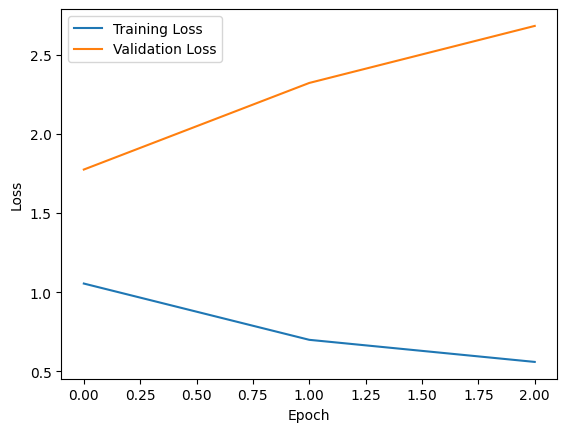

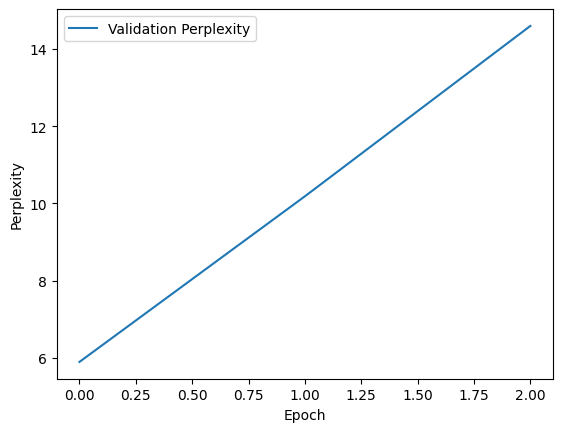

In [20]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.show()


In [23]:
# LSTM training report (uses existing notebook variables)
embedding_dim = getattr(model, 'embedding').embedding_dim if hasattr(model, 'embedding') else 128
hidden_dim = getattr(getattr(model, 'lstm'), 'hidden_size') if hasattr(model, 'lstm') else 256
num_layers = getattr(getattr(model, 'lstm'), 'num_layers') if hasattr(model, 'lstm') else 2
opt_name = optimizer.__class__.__name__ if 'optimizer' in globals() else 'Adam'
lr = optimizer.param_groups[0]['lr'] if 'optimizer' in globals() else 0.002
crit_name = criterion.__class__.__name__ if 'criterion' in globals() else 'CrossEntropyLoss'
device_name = device.upper() if 'device' in globals() else 'CPU'

best_val_ppl = float(min(val_perplexities)) if len(val_perplexities) > 0 else float('nan')
best_epoch = val_perplexities.index(min(val_perplexities)) + 1 if len(val_perplexities) > 0 else None

report_lstm = f"""
================================================================================
                    LSTM LANGUAGE MODEL TRAINING REPORT
================================================================================

DATASET INFORMATION:
  - Total Text Length: {len(encoded_text):,} characters
  - Vocabulary Size: {vocab_size} unique characters
  - Training Set Size: {len(train_encoded):,} characters ({(len(train_encoded)/len(encoded_text)*100):.1f}%)
  - Validation Set Size: {len(val_encoded):,} characters ({(len(val_encoded)/len(encoded_text)*100):.1f}%)

SEQUENCE & BATCH CONFIGURATION:
  - Sequence Length: {SEQ_LEN}
  - Batch Size: {BATCH_SIZE}
  - Training Samples: {len(train_dataset):,}
  - Validation Samples: {len(val_dataset):,}

MODEL ARCHITECTURE:
  - Model Type: LSTM Language Model
  - Embedding Dimension: {embedding_dim}
  - Hidden Dimension: {hidden_dim}
  - Number of LSTM Layers: {num_layers}
  - Output Vocabulary Size: {vocab_size}

TRAINING CONFIGURATION:
  - Number of Epochs: {NUM_EPOCHS}
  - Optimizer: {opt_name}
  - Learning Rate: {lr}
  - Loss Function: {crit_name}
  - Device: {device_name}

TRAINING RESULTS:
{chr(10).join([f'  Epoch {i+1}: Train Loss = {train_losses[i]:.4f}, Val Loss = {val_losses[i]:.4f}, Val Perplexity = {val_perplexities[i]:.2f}'
                for i in range(min(len(train_losses), len(val_losses), len(val_perplexities)) )])}

FINAL METRICS:
  - Final Training Loss: {train_losses[-1]:.4f}
  - Final Validation Loss: {val_losses[-1]:.4f}
  - Final Validation Perplexity: {val_perplexity:.2f}
  - Best Validation Perplexity: {best_val_ppl:.2f} (Epoch {best_epoch})

OBSERVATIONS:
  - Training Loss Trend: {('Decreasing' if train_losses[-1] < train_losses[0] else 'Increasing')}
  - Validation Loss Trend: {('Decreasing' if val_losses[-1] < val_losses[0] else 'Increasing')}
  - Overfitting Status: {'Moderate overfitting detected' if val_losses[-1] - train_losses[-1] > 0.5 else 'Within acceptable range'}

================================================================================
"""

print(report_lstm)


                    LSTM LANGUAGE MODEL TRAINING REPORT

DATASET INFORMATION:
  - Total Text Length: 711,331 characters
  - Vocabulary Size: 90 unique characters
  - Training Set Size: 640,197 characters (90.0%)
  - Validation Set Size: 71,134 characters (10.0%)

SEQUENCE & BATCH CONFIGURATION:
  - Sequence Length: 100
  - Batch Size: 64
  - Training Samples: 640,097
  - Validation Samples: 71,034

MODEL ARCHITECTURE:
  - Model Type: LSTM Language Model
  - Embedding Dimension: 128
  - Hidden Dimension: 256
  - Number of LSTM Layers: 2
  - Output Vocabulary Size: 90

TRAINING CONFIGURATION:
  - Number of Epochs: 3
  - Optimizer: Adam
  - Learning Rate: 0.002
  - Loss Function: CrossEntropyLoss
  - Device: CPU

TRAINING RESULTS:
  Epoch 1: Train Loss = 1.0546, Val Loss = 1.7743, Val Perplexity = 5.90
  Epoch 2: Train Loss = 0.6993, Val Loss = 2.3211, Val Perplexity = 10.19
  Epoch 3: Train Loss = 0.5598, Val Loss = 2.6810, Val Perplexity = 14.60

FINAL METRICS:
  - Final Training Loss:

Save the model of LSTM

In [26]:
torch.save(model.state_dict(), 'Code_LSTM_best_model.pth')


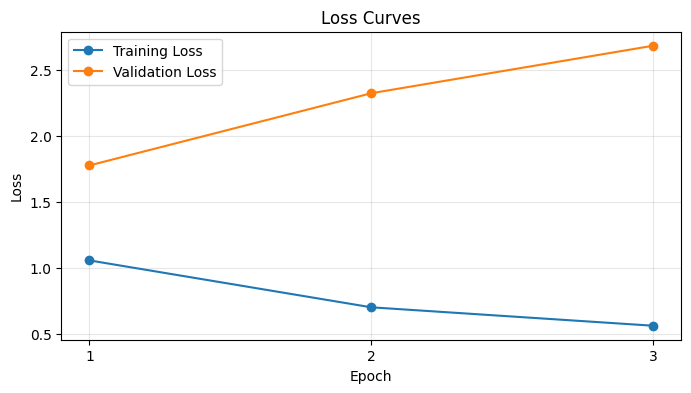

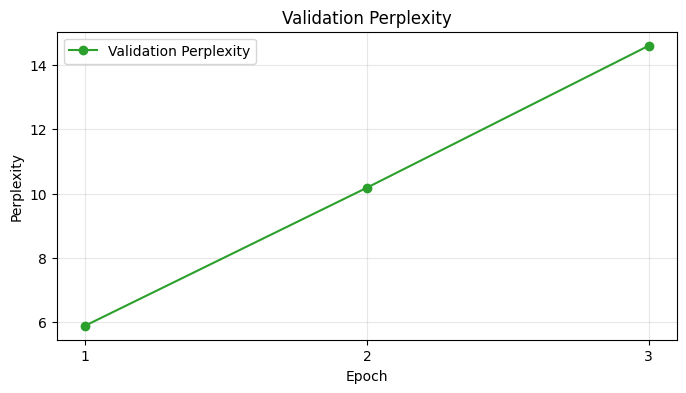

In [22]:
# Re-plot loss and perplexity curves
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.xticks(epochs)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, val_perplexities, marker='o', color='C2', label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity')
plt.xticks(epochs)
plt.yscale('log' if max(val_perplexities) / min(val_perplexities) > 10 else 'linear')
plt.legend()
plt.grid(alpha=0.3)
plt.show()